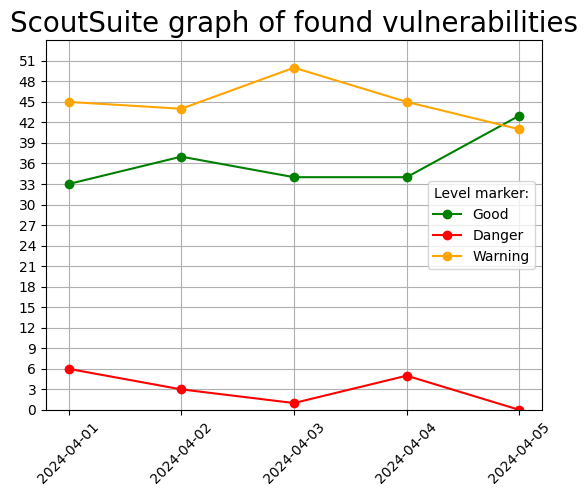

In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import time

def get_state(checked, flagged, level):
    if checked != 0:
        if flagged != 0:
            return level
        else:
            return 'good'
    return None

def get_param_from_json(file_name):

    file_name = os.path.join(folder_path, file_name)

    with open(file_name, "r") as f:
        data = json.load(f)

    dict_counter = {'good':0, 'danger':0, 'warning':0}
    
    date_time = data['last_run']['time']
    
    for service in data['services']:
        for i in data['services'][service]['findings']:

            item = data['services'][service]['findings'][i]
            state = get_state(item['checked_items'], item['flagged_items'], item['level'])
            if state is not None:
                dict_counter[state] += 1

    return dict_counter, date_time


folder_path = '/home/pespav/Projects_GCP/venv/scoutsuite-report/scoutsuite-results/'

files_list = os.listdir(folder_path)

filtered_files_list = [file for file in files_list if file.startswith('scoutsuite_results_gcp-study-project-414406_') and file.endswith('.json')]

filtered_files_list = sorted(filtered_files_list)

good, danger, warning = [],[],[]

file_dates = []

for file in filtered_files_list:
    d, date_time = get_param_from_json(file)

    good.append(d["good"])
    danger.append(d["danger"])
    warning.append(d["warning"])

    file_dates.append(date_time[:-14])


# Настройка цветов линий и точек
plt.plot(good, color='green', marker='o', label='Good')
plt.plot(danger, color='red', marker='o', label='Danger')
plt.plot(warning, color='orange', marker='o', label='Warning')

# Добавление сетки
plt.grid(True)

plt.title(label="ScoutSuite graph of found vulnerabilities",
          fontsize=20)

# Добавление легенды
plt.legend(title='Level marker:')

# Установка меток оси x с числовым форматом дат
plt.xticks(range(len(file_dates)), file_dates, rotation=45)

# Установка меток на оси y через каждые 2 значения
plt.yticks(range(0, max(max(good), max(danger), max(warning)) + 4, 3))

# Установка диапазона значений на оси y
plt.ylim(0, max(max(good), max(danger), max(warning)) + 4)


plt.show()

In [119]:
type(date_time)

str

In [141]:
result_to_csv = pd.DataFrame(columns=['date_time', 'status', 'description', 'rationale', 'compliance', 'references', 'old_risk_level', 'new_risk_level'])

result_to_csv

,date_time,status,description,rationale,compliance,references,old_risk_level,new_risk_level


In [2]:
for idx in range(1, len(filtered_files_list)):
    
    file_name1 = os.path.join(folder_path, filtered_files_list[idx-1])
    file_name2 = os.path.join(folder_path, filtered_files_list[idx])

    with open(file_name1, "r") as f:
        data1 = json.load(f)

    with open(file_name2, "r") as f:
        data2 = json.load(f)

    for service in data1['services']:
        for service_name in data1['services'][service]['findings']:

            item1 = data1['services'][service]['findings'][service_name]
            item2 = data2['services'][service]['findings'][service_name]
            
            state1 = get_state(item1['checked_items'], item1['flagged_items'], item1['level'])
            state2 = get_state(item2['checked_items'], item2['flagged_items'], item2['level'])
            
            status = 'new' if state2 is not None and state1 is None else 'deleted' if state2 is None and state1 is not None else 'changed'


            if state2 != state1:
                
                data_dict_list = [
                    {
                        'date_time': data2['last_run']['time'],
                        'status': status,
                        'description': item2['description'],
                        'rationale': item2['rationale'],
                        'compliance': item2['compliance'],
                        'references': item2['references'],
                        'old_risk_level':state1,
                        'new_risk_level': state2
                    }
                ]

                df = pd.DataFrame(data_dict_list, columns=['date_time', 'status', 'description', 'rationale', 'compliance', 'references', 'old_risk_level', 'new_risk_level'])

                result_to_csv = pd.concat([result_to_csv, df], ignore_index=True)

current_time = time.time()

formatted_time = time.strftime('%Y-%m-%d_%H:%M:%S', time.localtime(current_time))

result_to_csv.to_csv(f'report_csv_{formatted_time}.csv')

NameError: name 'result_to_csv' is not defined

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

class ScoutSuiteAnalyzer:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.result_to_csv = pd.DataFrame(columns=['date_time', 'status', 'description', 'rationale', 'compliance', 'references', 'old_risk_level', 'new_risk_level'])

    def get_state(self, checked, flagged, level):
        """
        Определяет состояние уязвимости на основе количества проверенных и помеченных элементов

        Parameters:
        - checked (int): Количество проверенных элементов
        - flagged (int): Количество помеченных элементов
        - level (str): Уровень уязвимости

        Return:
        - str: Состояние уязвимости ('good', 'danger', 'warning' или None)
        """
        if checked != 0:
            if flagged != 0:
                return level
            else:
                return 'good'
        return None

    def get_param_from_json(self, file_name):
        """
        Извлекает параметры из JSON-файла результатов ScoutSuite
        """
        file_path = os.path.join(self.folder_path, file_name)

        with open(file_path, "r") as f:
            data = json.load(f)

        dict_counter = {'good': 0, 'danger': 0, 'warning': 0}
        date_time = data['last_run']['time']

        for service in data['services']:
            for i in data['services'][service]['findings']:
                item = data['services'][service]['findings'][i]
                state = self.get_state(item['checked_items'], item['flagged_items'], item['level'])
                if state is not None:
                    dict_counter[state] += 1

        return dict_counter, date_time

    def analyze_files(self):
        """
        Анализирует файлы JSON с результатами проверки уязвимостей и создает CSV-отчет

        :param folder_path: Путь к папке с файлами JSON
        """
        files_list = os.listdir(self.folder_path)
        filtered_files_list = [file for file in files_list if file.startswith('scoutsuite_results_gcp-study-project-414406_') and file.endswith('.json')]
        filtered_files_list = sorted(filtered_files_list)

        for idx in range(1, len(filtered_files_list)):
            file_name1 = os.path.join(self.folder_path, filtered_files_list[idx-1])
            file_name2 = os.path.join(self.folder_path, filtered_files_list[idx])

            with open(file_name1, "r") as f:
                data1 = json.load(f)

            with open(file_name2, "r") as f:
                data2 = json.load(f)

            for service in data1['services']:
                for service_name in data1['services'][service]['findings']:
                    item1 = data1['services'][service]['findings'][service_name]
                    item2 = data2['services'][service]['findings'][service_name]

                    state1 = self.get_state(item1['checked_items'], item1['flagged_items'], item1['level'])
                    state2 = self.get_state(item2['checked_items'], item2['flagged_items'], item2['level'])

                    status = 'new' if state2 is not None and state1 is None else 'deleted' if state2 is None and state1 is not None else 'changed'

                    if state2 != state1:
                        data_dict_list = [
                            {
                                'date_time': data2['last_run']['time'],
                                'status': status,
                                'description': item2['description'],
                                'rationale': item2['rationale'],
                                'compliance': item2['compliance'],
                                'references': item2['references'],
                                'old_risk_level': state1,
                                'new_risk_level': state2
                            }
                        ]

                        df = pd.DataFrame(data_dict_list, columns=['date_time', 'status', 'description', 'rationale', 'compliance', 'references', 'old_risk_level', 'new_risk_level'])
                        self.result_to_csv = pd.concat([self.result_to_csv, df], ignore_index=True)

        current_time = time.time()
        formatted_time = time.strftime('%Y-%m-%d_%H:%M:%S', time.localtime(current_time))
        csv_file_path = os.path.join(self.folder_path, f'report_csv_{formatted_time}.csv')
        self.result_to_csv.to_csv(csv_file_path)

    def plot_vulnerabilities(self, csv_file_path):
        good, danger, warning, file_dates = self.analyze_files()

        plt.plot(good, color='green', marker='o', label='Good')
        plt.plot(danger, color='red', marker='o', label='Danger')
        plt.plot(warning, color='orange', marker='o', label='Warning')
        plt.grid(True)
        plt.title(label="ScoutSuite graph of found vulnerabilities", fontsize=20)
        plt.legend(title='Level marker:')
        plt.xticks(range(len(file_dates)), file_dates, rotation=45)
        plt.yticks(range(0, max(max(good), max(danger), max(warning)) + 4, 3))
        plt.ylim(0, max(max(good), max(danger), max(warning)) + 4)
        plt.show()
        graph_file_path = os.path.join(os.path.dirname(folder_path), 'vulnerability_graph.png')
        plt.savefig(graph_file_path)



folder_path = os.getenv('SCOUTSUITE_RESULTS_PATH')
analyzer = ScoutSuiteAnalyzer(folder_path)
analyzer.plot_vulnerabilities()
